# Classifiers for all targets
Let's train classifiers for all target for different molecular represenatations and compare results. The next step will involve the optimization of hyperparameters for each classifier. `mlflow` will be used for experiment management.<br>

To launch the mlflow server run:
```bash
cd mlflow
mlflow ui --backend-store-uri sqlite:///mlflow.db
```

In [1]:
# suppress warnings
import warnings
warnings.filterwarnings("ignore")

import polars as pl
from pathlib import Path
import random
import pickle
from sklearn.ensemble import RandomForestClassifier
from tqdm.notebook import tqdm
import seaborn as sns
import pandas as pd

# add parent directory to path
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))

from metrics import ClassificationMetrics
from tools import expand_array_column, train_classifier

In [2]:
import mlflow
mlflow.set_tracking_uri("sqlite:///../mlflow/mlflow.db")
mlflow.set_experiment("mol-reprs-benchmark")

2024/06/15 19:48:09 INFO mlflow.store.db.utils: Creating initial MLflow database tables...
2024/06/15 19:48:09 INFO mlflow.store.db.utils: Updating database tables
INFO  [alembic.runtime.migration] Context impl SQLiteImpl.
INFO  [alembic.runtime.migration] Will assume non-transactional DDL.
INFO  [alembic.runtime.migration] Running upgrade  -> 451aebb31d03, add metric step
INFO  [alembic.runtime.migration] Running upgrade 451aebb31d03 -> 90e64c465722, migrate user column to tags
INFO  [alembic.runtime.migration] Running upgrade 90e64c465722 -> 181f10493468, allow nulls for metric values
INFO  [alembic.runtime.migration] Running upgrade 181f10493468 -> df50e92ffc5e, Add Experiment Tags Table
INFO  [alembic.runtime.migration] Running upgrade df50e92ffc5e -> 7ac759974ad8, Update run tags with larger limit
INFO  [alembic.runtime.migration] Running upgrade 7ac759974ad8 -> 89d4b8295536, create latest metrics table
INFO  [89d4b8295536_create_latest_metrics_table_py] Migration complete!
INFO  

<Experiment: artifact_location='/home/anton/Projects/PythonProjects/mol-reprs-benchmark/nbs/mlruns/1', creation_time=1718473689634, experiment_id='1', last_update_time=1718473689634, lifecycle_stage='active', name='mol-reprs-benchmark', tags={}>

In [3]:
path_parquet = Path("../data/2023_09_12_papyrus1k_dataset_more_params_STD_MFP_lessColumns.parquet")
assert path_parquet.exists()

Define paths to precomputed fingerprints:

In [4]:
path_fps = Path("../out/fingerprints_dicts")
assert path_fps.exists()

paths_fingerprints = list(path_fps.glob("*.pkl"))
def fps_name(fps_path): return fps_path.name.split(".")[0][2:]
fps_names = [fps_name(x) for x in paths_fingerprints]

Load data and train classifier:

In [5]:
df = pl.read_parquet(path_parquet)

In [6]:
for path_fingerprint, fps_name in tqdm(zip(paths_fingerprints, fps_names)):
    # load fingerpriint to test and correspoinding name
    with open(path_fingerprint, "rb") as f:
        d_fps = pickle.load(f)

    for target_id in tqdm(df["target_id"].unique().to_list()):

        with mlflow.start_run():

            mlflow.set_tag("model_type", "random_forest")
            mlflow.set_tag("dataset", "Papyrus1K")
            mlflow.set_tag("fingerprint", fps_name)

            mlflow.log_param("target_id", target_id)

            df_target = df.filter(pl.col("target_id") == target_id)
            df_target = df_target.drop(["target_id", "STD_SELFIES"])

            df_target = df_target.with_columns(
                fp = pl.col("STD_SMILES").map_elements(lambda x: d_fps[x])
            )
            
            # number of features
            k = list(d_fps.keys())[0]
            n_features = len(d_fps[k])
            df_target = expand_array_column(df_target, "fp", n_features)

            # Define the model with hyperparameters
            n_estimators = 1000
            random_state = 42
            model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)

            mlflow.log_param("n_estimators", n_estimators)
            mlflow.log_param("random_state", random_state)

            metrics = train_classifier(model, df_target, target_id)
            mlflow.log_metric("mcc_train", metrics.mcc_train)
            mlflow.log_metric("mcc_val", metrics.mcc_val)
            mlflow.log_metric("mcc_test", metrics.mcc_test)

0it [00:00, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

Extract metrics from `mlflow` and visualize them. This allows not create additional data structure to store metrics.

In [7]:
# all_runs = mlflow.search_runs(search_all_experiments=True)
all_runs = mlflow.search_runs(experiment_ids=[1], order_by=["metrics.mcc_test DESC"])

In [8]:
all_runs.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.mcc_train', 'metrics.mcc_test', 'metrics.mcc_val',
       'params.target_id', 'params.n_estimators', 'params.random_state',
       'tags.mlflow.source.name', 'tags.dataset', 'tags.mlflow.source.type',
       'tags.fingerprint', 'tags.mlflow.user', 'tags.mlflow.runName',
       'tags.model_type'],
      dtype='object')

In [9]:
all_runs.head()

,run_id,experiment_id,status,artifact_uri,start_time,end_time,metrics.mcc_train,metrics.mcc_test,metrics.mcc_val,params.target_id,params.n_estimators,params.random_state,tags.mlflow.source.name,tags.dataset,tags.mlflow.source.type,tags.fingerprint,tags.mlflow.user,tags.mlflow.runName,tags.model_type
0,fbafd02a42d349eeb0665dac9685c3b8,1,FINISHED,/home/anton/Projects/PythonProjects/mol-reprs-...,2024-06-15 19:11:18.822000+00:00,2024-06-15 19:11:19.784000+00:00,0.947404,1.000000,1.000000,P34976_WT,1000,42,/home/anton/.pyenv/versions/mambaforge/envs/be...,Papyrus1K,LOCAL,maccs,anton,painted-bat-390,random_forest
1,404f83998ea64e4a993143d4211e7743,1,FINISHED,/home/anton/Projects/PythonProjects/mol-reprs-...,2024-06-15 18:13:05.139000+00:00,2024-06-15 18:13:07.796000+00:00,0.965402,1.000000,1.000000,P34976_WT,1000,42,/home/anton/.pyenv/versions/mambaforge/envs/be...,Papyrus1K,LOCAL,topological_torsion,anton,dapper-hawk-540,random_forest
2,df6984fd5c584f7bb684df86376192e0,1,FINISHED,/home/anton/Projects/PythonProjects/mol-reprs-...,2024-06-15 19:31:08.445000+00:00,2024-06-15 19:31:12.955000+00:00,1.000000,0.941523,0.858315,P55055_WT,1000,42,/home/anton/.pyenv/versions/mambaforge/envs/be...,Papyrus1K,LOCAL,morgan,anton,unleashed-pig-996,random_forest
3,6cdad6ed41164db095ce704b261ce34a,1,FINISHED,/home/anton/Projects/PythonProjects/mol-reprs-...,2024-06-15 21:34:20.906000+00:00,2024-06-15 21:34:24.680000+00:00,1.000000,0.918706,0.813973,P80457_WT,1000,42,/home/anton/.pyenv/versions/mambaforge/envs/be...,Papyrus1K,LOCAL,atom_pairs,anton,puzzled-wasp-507,random_forest
4,8e5b18f7494e4f2db78c0799df2ed03f,1,FINISHED,/home/anton/Projects/PythonProjects/mol-reprs-...,2024-06-15 19:20:27.070000+00:00,2024-06-15 19:20:29.934000+00:00,0.997380,0.918401,0.860753,P80457_WT,1000,42,/home/anton/.pyenv/versions/mambaforge/envs/be...,Papyrus1K,LOCAL,morgan,anton,shivering-mouse-422,random_forest


In [10]:
# generate df_metrics from all_runs dataframe
df_metrics = all_runs[["params.target_id", "metrics.mcc_test", "metrics.mcc_train", "metrics.mcc_val", "tags.fingerprint"]].copy()
df_metrics = df_metrics.rename(columns={"params.target_id": "target_id", "metrics.mcc_test": "mcc_test",
                                        "metrics.mcc_train": "mcc_train", "metrics.mcc_val": "mcc_val", "tags.fingerprint": "fps_name"})
df_metrics

,target_id,mcc_test,mcc_train,mcc_val,fps_name
0,P34976_WT,1.000000,0.947404,1.000000,maccs
1,P34976_WT,1.000000,0.965402,1.000000,topological_torsion
2,P55055_WT,0.941523,1.000000,0.858315,morgan
3,P80457_WT,0.918706,1.000000,0.813973,atom_pairs
4,P80457_WT,0.918401,0.997380,0.860753,morgan
...,...,...,...,...,...
1115,Q99572_WT,-0.033942,0.996021,0.503367,morgan
1116,Q99572_WT,-0.048290,1.000000,0.560053,atom_pairs
1117,Q92847_WT,-0.048447,0.994496,0.509430,atom_pairs
1118,Q92847_WT,-0.048447,0.811466,0.279918,topological_torsion


Final comparison of performance of different fingerprints:

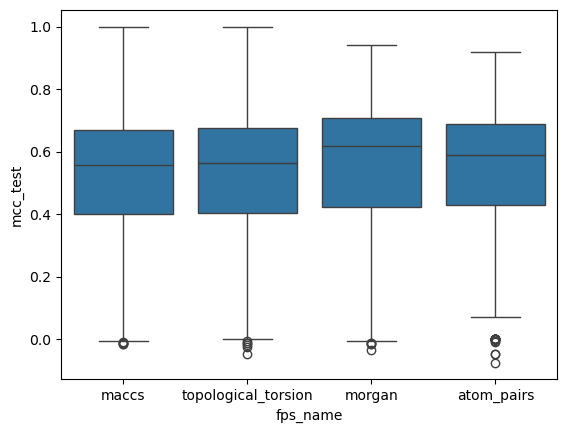

In [11]:
sns.boxplot(x="fps_name", y="mcc_test", data=df_metrics);